## Polygenic scores CCA
Inputs:
- polygenic scores from reading, dyslexia and handedness GWASes using PRS-CS
- language network connectivity and asymmetries based on the AICHA analysis

Output:
- figure that shows loadings and overall association pattern with each of the polygenic scores

In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
from sklearn.preprocessing import quantile_transform
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#### Helper functions

In [2]:
def read_pgs_chr(fn, chr_no):
    data = pd.read_csv(fn, sep="\s+", engine="python", na_values='-9')
    return data.rename(columns={"SCORESUM":"score_c{}".format(chr_no)})

def get_pgs(fn, pheno_name):
    file_list = [fn.format(pheno_name, chr_no) for chr_no in range(1,23)]
    data = pd.concat(map(read_pgs_chr, file_list, range(1,23)), join="inner", axis=1).T.drop_duplicates().T
    chrom_scores = ["score_c{0}".format(i) for i in range(1,23)]
    data["score_{0}".format(pheno_name)] = np.sum(data[chrom_scores].to_numpy(),axis=1)
    return data[["FID", "score_{0}".format(pheno_name)]]

def get_all_pgs(fn, pheno_list):
    return pd.concat(map(get_pgs, [fn]*len(pheno_list), pheno_list), join="inner", axis=1).T.drop_duplicates().T    

def load_column_names(fn):
    return [str(x) for x in open( fn ).read().split('\n')[:-1] ]

def residualize(data, covs, drop_all=True):
    #input_file = file_name + '.csv'
    #data = pd.read_csv(input_file)
    #data = data.set_index(data.columns[0]) 
    #data = data.loc[exome_subs]

    if drop_all:
        data = data.dropna()
        data = data.sort_index()
        #data[data.isnull()] = 0
        missing_sub = list((set(list(covs.index.values)).difference(list(data.index.values))))
        print("No. subjects missing from subject file: ", len(missing_sub))
        covs=covs.loc[data.index.values]

        #define new dataframe
        data_new=pd.DataFrame(columns=data.columns, index=data.index.values)

        #residualize
        for dep_var in data.columns: 
            model = sm.OLS(data[dep_var], exog=covs)
            results = model.fit()
            data_new[dep_var] = results.resid
    
            
    #quantile transformation
    X = data_new.to_numpy()
    data_new2 = pd.DataFrame(data=quantile_transform(X, n_quantiles=1000, output_distribution='normal', random_state=0, copy=True), columns=data_new.columns, index=data_new.index.values)
    return data_new2


#### Plotting function

In [3]:
from nilearn import plotting, image
from matplotlib import cm

def load_column_names(fn):
    return [str(x) for x in open( fn ).read().split('\n')[:-1] ]  

def get_edge_names(list_names):
    """
    Returns edge combinations for edges
    """
    df_names=pd.DataFrame(index=list_names, columns=list_names)
    for i in range(len(list_names)):
        for j in range(len(list_names)):
            df_names.iloc[i, j] = list_names[i]+"*"+list_names[j]
            
    #heritable = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt") + load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
    #heritable = ["sent_edges_"+x for x in heritable]
    
    return [x for x in list(df_names.to_numpy()[np.triu_indices(len(list_names), k=1)].flatten()) if x in heritable]


def get_idx(cat):
    """
    Returns indices for category
    """
    sent_core_l_ind = [2, 30, 32, 40, 56, 98, 102, 146, 148, 166, 168, 170, 172, 174, 182, 184, 222, 224]
    sent_core_r_ind = [3, 31, 33, 41, 57, 99, 103, 147, 149, 167, 169, 171, 173, 175, 183, 185, 223, 225]
    sent_core_bi_ind = sorted(sent_core_l_ind + sent_core_r_ind)
    
    if cat == "edges":
        return sent_core_bi_ind
    elif cat == "edges_HD":
        return sent_core_l_ind
    
    
def set_up_coordinates(cat):
    """
    get coordinates for plot
    """
    #set up atlas + coordinates
    aicha_atlas = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/multilateral/FuncNet_AICHA/segs/AICHA.nii"
    aicha_img = image.load_img(aicha_atlas)
    aicha_coords = plotting.find_parcellation_cut_coords(aicha_img)
    
    #indices
    idx = get_idx(cat)

    #get coordinates and names
    return aicha_coords[idx, :]

def get_names_aicha(cat):
    """
    Return node names
    """
    aicha_test = "/data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/AICHA/1000099/AICHA_timeseries_NO_GSR_cormat.txt"
    aicha2 = pd.read_csv(aicha_test, sep=";", index_col=0)
    
    idx = get_idx(cat)
    
    if cat == "edges":
        return list(aicha2.columns[idx]) #[x for x in list(aicha2.columns[idx]) if x in heritable]
    elif cat == "edges_HD":
        return list(x[:-2] for x in aicha2.columns[idx]) #[x for x in list(aicha2.columns[idx]) if x in heritable]


def make_nice_mat(input_data, cat, var_name):
    """
    put data from column into right spot in matrix
    """
    #get indices
    ind_names = get_names_aicha(cat)
        
    #set up dataframe
    df_out = pd.DataFrame(index=ind_names, columns=ind_names)
    df_out.iloc[np.diag_indices(len(ind_names)), np.diag_indices(len(ind_names))] = 0
    
    #put data in right place
    for x in list(input_data.columns):
        nodes = x.split("*", 1)
        df_out.loc[nodes[0], nodes[1]] = input_data.loc[var_name, x]
        df_out.loc[nodes[1], nodes[0]] = input_data.loc[var_name, x]
    
    return df_out
        
    
def plot_results_brain_cca(data, cat, brain_pheno, beh_pheno, ax, vmax_in=None, out=None):
    """
    Main function:
    - loads data
    - significance testing
    - plot using nilearn
    """
    #get correlation values
    load_mat = make_nice_mat(data, cat, beh_pheno)  
    
    #make colormap
    colors = ["mediumblue", "cornflowerblue", "lightgrey", "whitesmoke", "lightgrey", "lightcoral", "indianred"]
    cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
           
    if vmax_in is None:
        vmax_in = np.max(np.max(load_mat))
        
    if beh_pheno == "score_read":
        fig_title = 'language-related polygenic score'
    elif beh_pheno == "score_hand":
        fig_title = 'left-handedness polygenic score'
    elif beh_pheno == "score_dyslexia":
        fig_title = 'dyslexia polygenic score'
    else:
        fig_title = beh_pheno[6:]
    
    #plot
    if np.abs(data.sum().sum()) < 0.0001:
        plotting.plot_markers([1]*len(load_mat),
                              set_up_coordinates(cat), 
                              node_cmap="binary",
                              node_size=30,
                              alpha=0.8, 
                              display_mode='lyrz',
                              axes=ax, 
                              title=fig_title, 
                              colorbar=False)
        
    else:    
        plotting.plot_connectome(load_mat.to_numpy(dtype=float),
                             set_up_coordinates(cat),
                             title=fig_title,
                             #edge_cmap="coolwarm",
                             edge_vmin=-vmax_in,
                             edge_vmax=vmax_in,
                             edge_cmap=cmap1,
                             node_color="dimgrey",
                             node_size=30,
                             display_mode="lyrz",
                             colorbar=True,
                             alpha=0.8,
                             axes=ax)
                             #output_file=out)    


### 1. Load CCA results

In [4]:
df_loadings = pd.read_csv("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/CCA_loadings.csv", index_col=0)
df_loadings_asym = pd.read_csv("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/CCA_loadings_asym.csv", index_col=0)
df_corrs = pd.read_csv("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/CCA_corr.csv", index_col=0)
df_corrs_asym = pd.read_csv("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/CCA_corr_asym.csv", index_col=0)

brain_phenos = load_column_names(os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE", "heritable_edges.txt"))
prs_pheno_names=["score_read", "score_dyslexia", "score_hand"]
brain_phenos_asym = load_column_names(os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE", "heritable_edges_asym.txt"))

In [5]:
make_dist_fig = False
if make_dist_fig:
    lang_null_dist = pd.read_csv("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/CCA_null_dist.csv", index_col=0)
    asym_null_dist = pd.read_csv("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/CCA_null_dist_asym.csv", index_col=0)
    sns.kdeplot(data=lang_null_dist.rename(index={"score_read":"score_lang_mv"}).T, bw_method=0.25)
    sns.kdeplot(data=asym_null_dist.rename(index={"score_read":"score_lang_mv"}).T, bw_method=0.25)
    plt.savefig("/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results/cca_null_dist.png")

### 2. Plotting

/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=

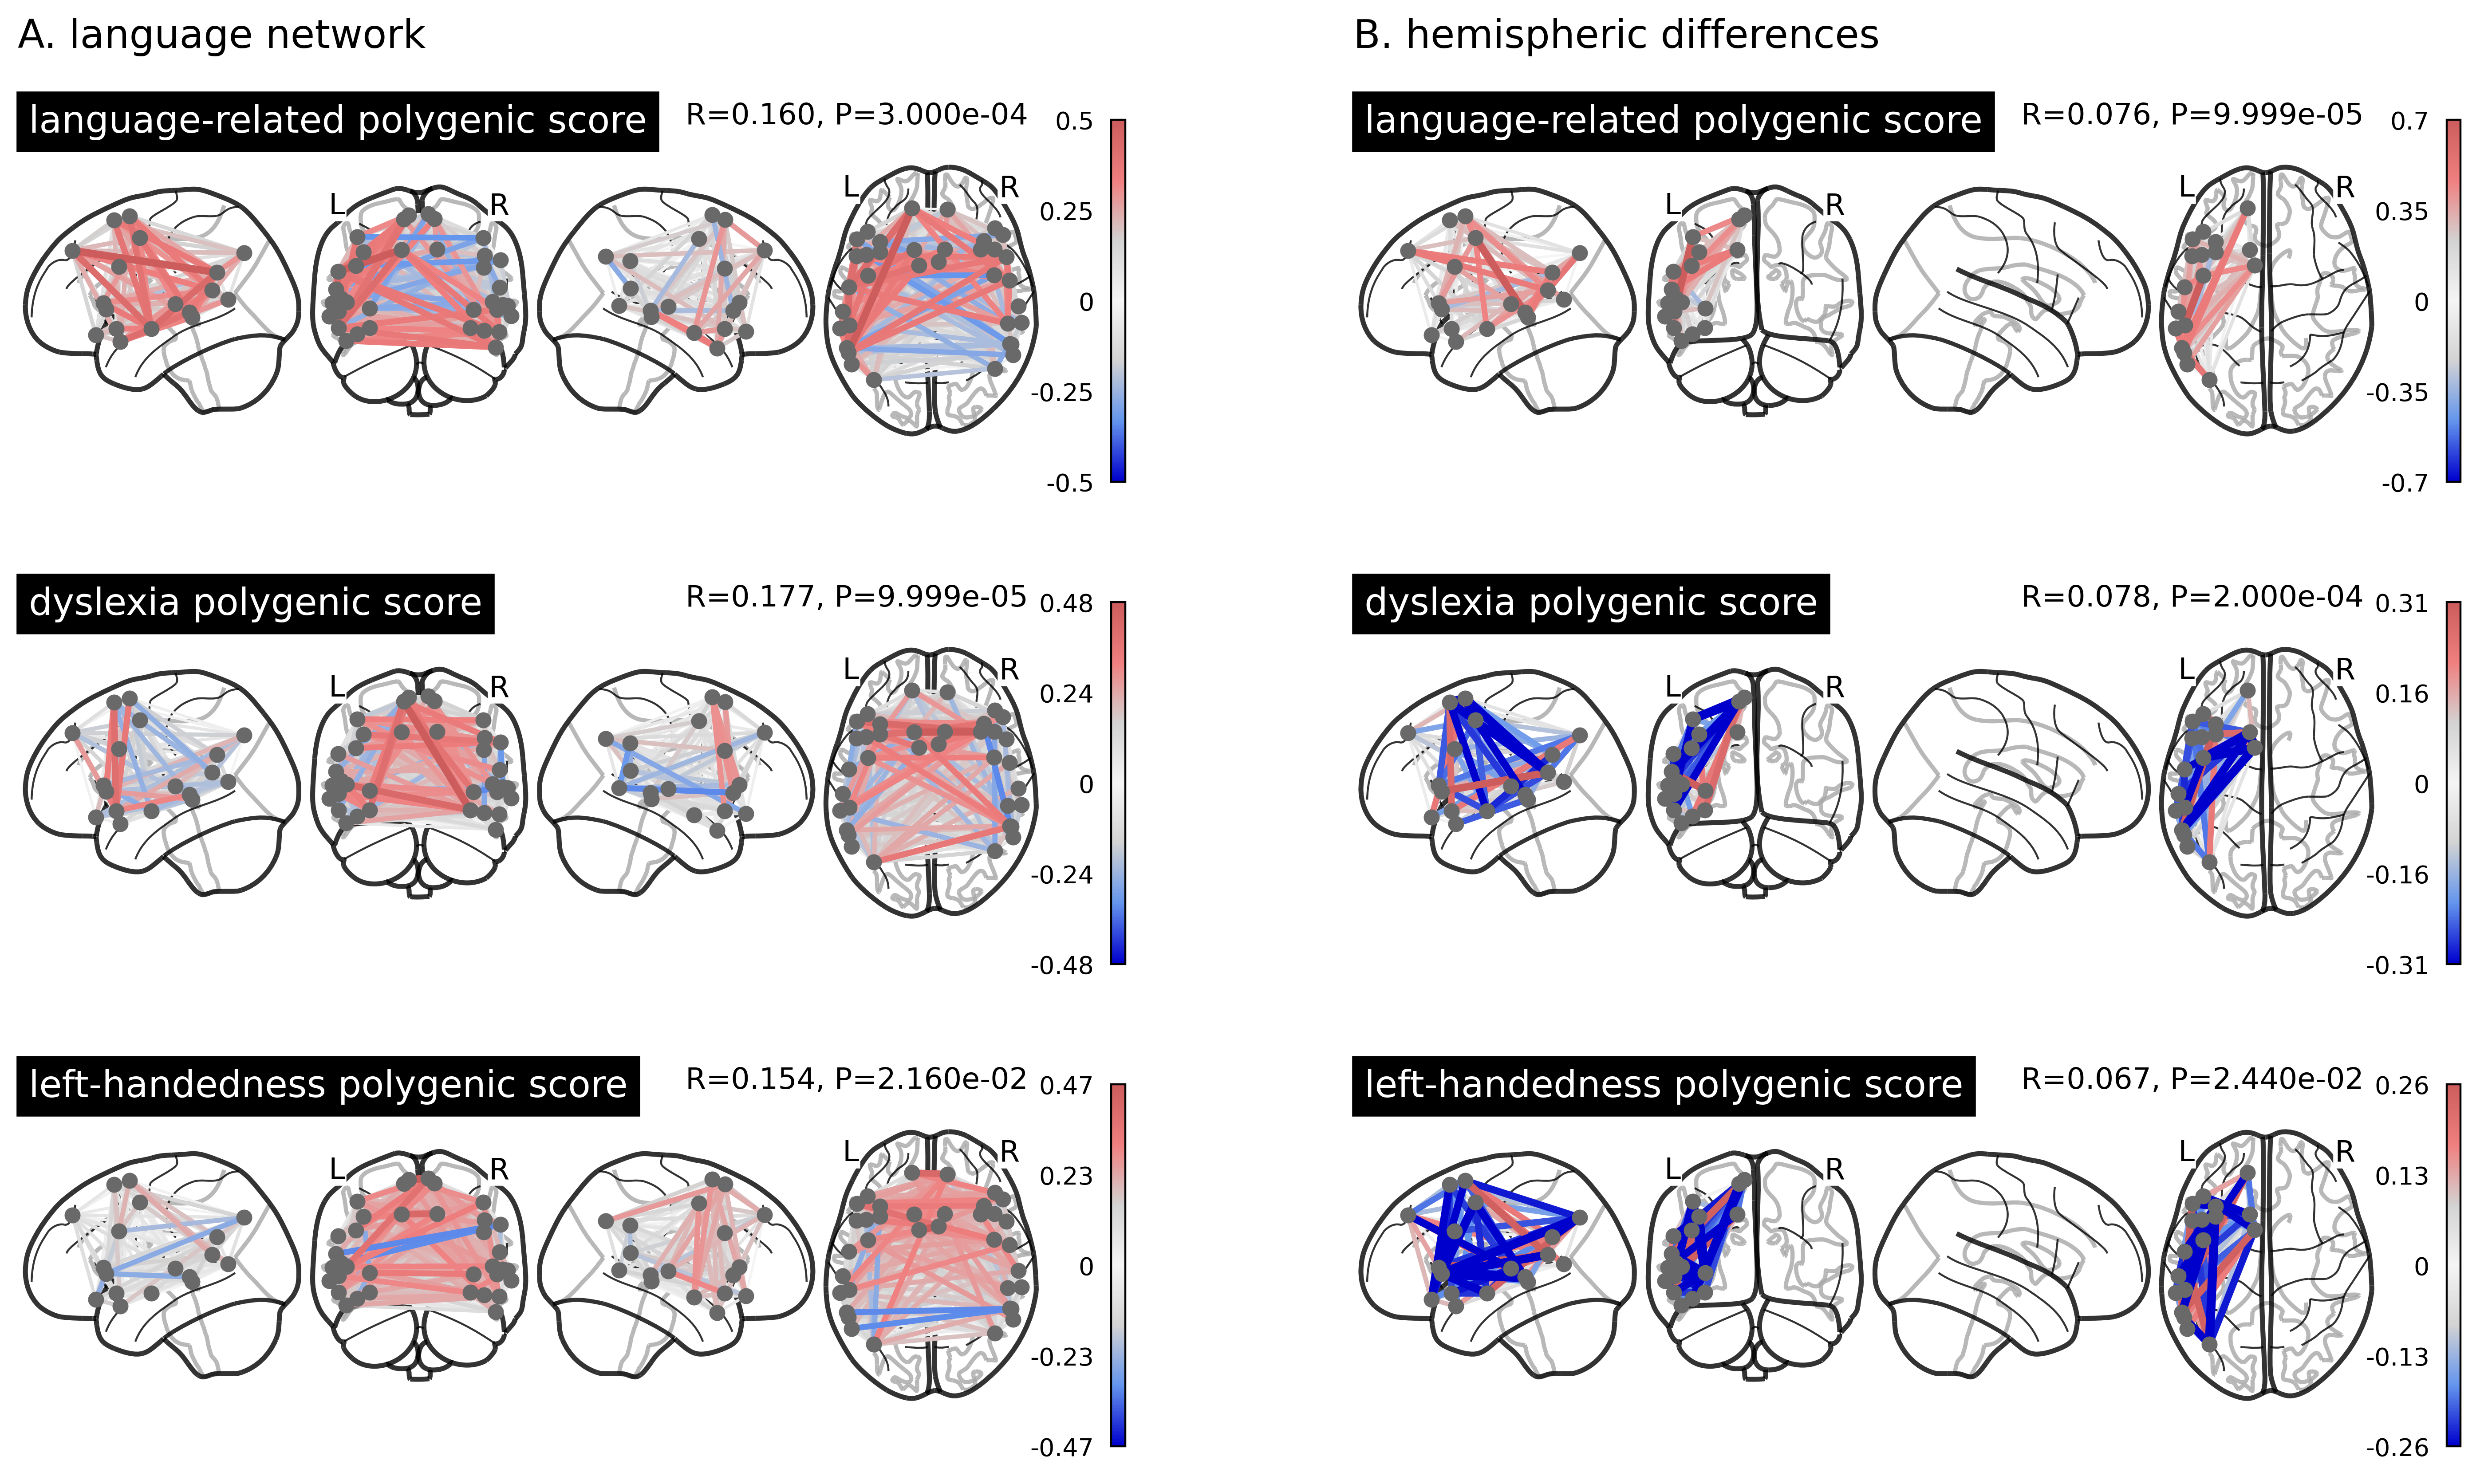

In [9]:
plot_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results"

vmax_in = None

fig_args = {"figsize":(17.8,10),"dpi":400}

fig, ax = plt.subplots(len(prs_pheno_names), 2, gridspec_kw={'height_ratios': [1]*len(prs_pheno_names)}, **fig_args)

for x, pheno_name in enumerate(prs_pheno_names):
    plot_results_brain_cca(data=df_loadings,
                           cat="edges",
                           brain_pheno="edge",
                           beh_pheno=pheno_name,
                           ax=ax[x, 0],
                           vmax_in=vmax_in,
                           out=None)
    ax[x, 0].text(0.6, 0.94, "R={:.3f}, P={:.3e}".format(df_corrs.loc[pheno_name, "R"], df_corrs.loc[pheno_name, "P"]), fontsize=12)

for x, pheno_name in enumerate(prs_pheno_names):
    plot_results_brain_cca(data=df_loadings_asym,
                           cat="edges_HD",
                           brain_pheno="edge hemispheric difference",
                           beh_pheno=pheno_name,
                           ax=ax[x, 1],
                           vmax_in=vmax_in,
                           out=None)
    
    ax[x, 1].text(0.6, 0.94, "R={:.3f}, P={:.3e}".format(df_corrs_asym.loc[pheno_name, "R"], df_corrs_asym.loc[pheno_name, "P"]), fontsize=12)

#fig.suptitle("Multivariate associations of polygenic scores with brain phenotypes", y=0.98, fontsize=24)
ax[0, 0].text(0, 1.13, "A. language network", fontsize=16)
ax[0, 1].text(0, 1.13, "B. hemispheric differences", fontsize=16)

plt.savefig(fname=os.path.join(plot_path, "Fig_2_CCA_results_v2.tif"), bbox_inches="tight")
plt.savefig(fname=os.path.join(plot_path, "Fig_2_CCA_results_v2.eps"), bbox_inches="tight")
plt.savefig(fname=os.path.join(plot_path, "Fig_2_CCA_results_v2.png"), bbox_inches="tight")